<font color="dodgerblue">**Spatial Plots of Average Percent Differences**</font>

<ins>Main_Purpose</ins> :This script works to create average spatial difference plots across all time-points between two CMAQ output files

<ins>Other_Features</ins>:
* Works with <font color="teal">**Lambert Conformal**</font> (CONUS and states/localities within) and <font color="purple">**Stereographically**</font> (N. Hemispheric) Projected output
    * (<font color = "darkorange">If you need another spatial domain not covered Sara Farrell can add one in!</font>)
* Showcases colorgrid options
* Extracts time, projection, species and units from file headers
* <font color="deeppink">Circles</font> the grid cell and area where the max average concentration and max average percent difference occurs

<ins>General Instructions</ins>:
1) You run each cell by clicking in it and then pressing Enter+Shift
2) You will be prompted to provide path destinations, file names, color schemes, etc
3) This is in it's beta form so if you have any feedback or need any help feel free to tag <font color="royalblue">**@slfarrell**</font> in the CMAS Forums for help

**_Importing Libraries_**

In [1]:
from netCDF4 import Dataset
import numpy as np
import pyproj
import matplotlib.pyplot as plt
from textwrap import wrap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import os
import pandas
import math

**_Pick from an assortment of color_schemes_**

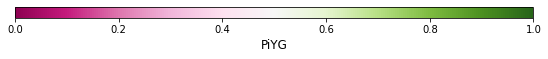

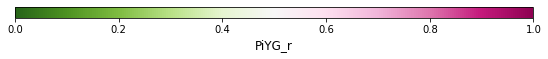

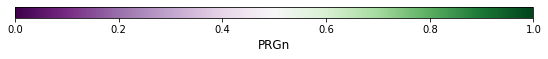

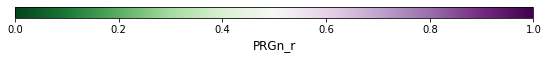

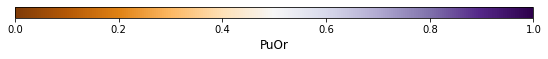

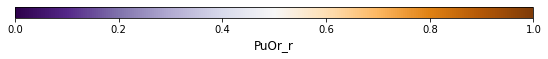

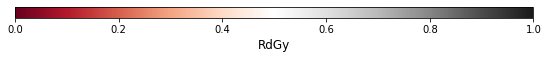

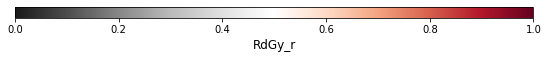

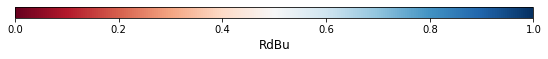

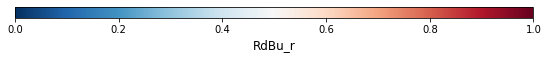

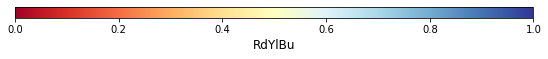

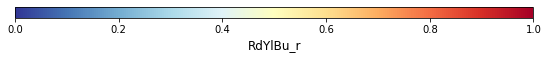

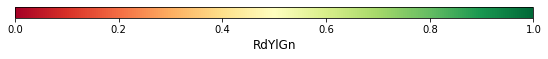

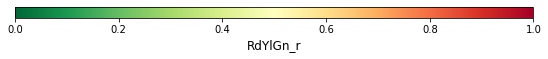

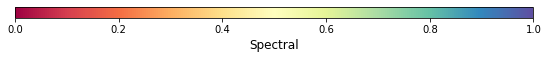

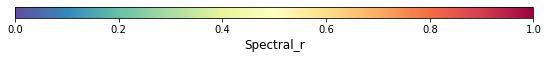

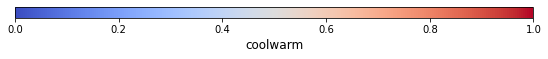

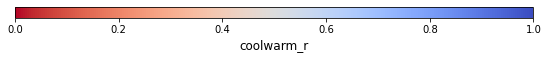

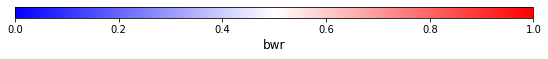

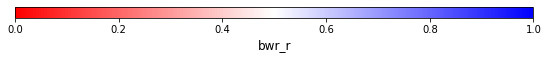

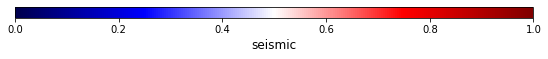

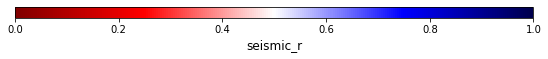

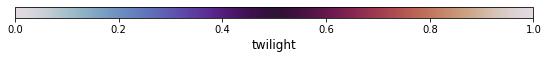

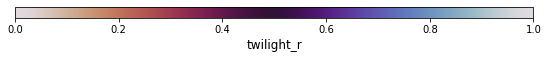

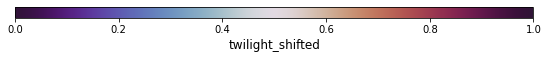

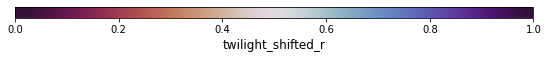

In [2]:
list_color_bars = plt.colormaps()
list_color_bars_strings = ['PiYG','PiYG_r','PRGn','PRGn_r','PuOr','PuOr_r','RdGy','RdGy_r','RdBu','RdBu_r','RdYlBu','RdYlBu_r','RdYlGn', 'RdYlGn_r',\
                           'Spectral','Spectral_r','coolwarm','coolwarm_r','bwr','bwr_r','seismic','seismic_r','twilight','twilight_r','twilight_shifted','twilight_shifted_r']

for l in range(len(list_color_bars_strings)):
    cmap = plt.get_cmap(list_color_bars_strings[l])
    a = np.array([[0,1]])
    plt.figure(figsize=(9, 1.5))
    img = plt.imshow(a, cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.1])
    bar = plt.colorbar(orientation="horizontal", cax=cax)
    bar.set_label(list_color_bars_strings[l],fontsize=12)
    plt.show()
    

**Things you will need to customize**
* path1 and path2 need to point to where your output files for your base (path1) and experimental (path2) are
* the headings that describe your base and experimental runs
* file1 and file2 are the names of your base and experimental files
* your cmap with your colorbar that you picked from above and set it to your color_scheme
* where you want your plots to be outputted
* the percent threshold below which you don't care about differences
* the time difference between your domain and GMT

**_Set up your Inputs (just Shift+Enter for each cell, answer the prompt in the box, and Shift+Enter again)_**

In [3]:
path1=("/work/MOD3DEV/sfarrell/OUT_HEMI_pv-nohet/POST/")

In [4]:
file1=("PM25_IJ_lyr1_winter_20152016.nc")

Specify the path for the sensitivity case

Specify your sensitivity file name

In [5]:
path2=("/work/MOD3DEV/sfarrell/OUT_HEMI_pv-allchem_basehet/OUT_HEMI_pv-allchem_basehet/POST/")

In [6]:
file2=("PM25_IJ_lyr1_winter_20152016.nc")

enter the title heading for your first/base file (i.e. Base CMAQ)

In [7]:
heading1='N Hemi Base CMAQ'

enter the title heading for your updated/sensitivity file (ie. DESID PT_EGU NY reduction)

In [8]:
heading2='Heterogeneous Sulfur Chemistry'

In [9]:
color_scheme = input('enter the name of the colorbar you want to use:')

enter the name of the colorbar you want to use: Spectral_r


Create an output directory to save the images

In [10]:
!mkdir -p /work/MOD3DEV/sfarrell/CMAQ_Eval_python/plots/new

enter your output directory

In [11]:
outputdir='/work/MOD3DEV/sfarrell/CMAQ_Eval_python/plots/new'

In [12]:
percent_change_threshold = input('enter the threshold value below which you do not care about the percent change (i.e. 10 for 10% but you can also put 0 if you are interested in all of the percent changes)):')

enter the threshold value below which you do not care about the percent change (i.e. 10 for 10% but you can also put 0 if you are interested in all of the percent changes)): 10


In [13]:
time_change = input('enter the time change between local and UTC (i.e. for Fairbanks, -8, for EST, -4, for Germany, 2)')

enter the time change between local and UTC (i.e. for Fairbanks, -8, for EST, -4, for Germany, 2) 0


In [14]:
time_zone_str = input('enter the time zone corresponding with the time_change selected')

enter the time zone corresponding with the time_change selected GMT


**_Run the cell below to check that your /directories/folders exist_**

(If you get any errors, <font color = "darkorange">fix and re-run</font> whichever prompt box applies and then check again)

In [15]:
if os.path.isdir(path1):
    pass
else:
    print('Error path1 does not exist')

if os.path.isdir(path2):
    pass
else:
    print('Error path2 does not exist')


if os.path.isfile(path1+'/'+file1):
    pass
else:
    print('Error: either path1 or file1 do not exist')
    
if os.path.isfile(path2+'/'+file2):
    pass
else:
    print('Error: either path2 or file2 do not exist')
    
if color_scheme not in list_color_bars_strings:
    print('Error: choose another color scheme')
    
if os.path.exists(outputdir):
    pass
else:
    print('Error: output directory does not exist')

<font color="deeppink">**R**</font><font color="darkorange">**U**</font><font color="goldenrod">**N**</font> <font color="green">**T**</font><font color="dodgerblue">**H**</font><font color="purple">**E**</font> <font color="deeppink">**S**</font><font color="darkorange">**C**</font><font color="goldenrod">**R**</font><font color="green">**I**</font><font color="dodgerblue">**P**</font><font color="purple">**T**</font>

(will likely take a bit depending on how many variables you are looping through but check at the bottom of the next cell for error messages that stop the script)

In [16]:
## Defines the inputs specified to loop through ##
path_combo1 = [path1, path2]

paths = [path_combo1]

comboheading1 = ' average difference between '+heading1+' vs '+heading2
for p in range(len(paths)):
    
    path_combo = paths[p]
    
    ## Extracts NetCDF Files##
    File1 = Dataset(path_combo[0]+'/'+file1, mode='r')
    File2 = Dataset(path_combo[1]+'/'+file2, mode='r')

    ## Extracts Model Start Date ##
    date_string = str(File1.SDATE)
    date_year = date_string[0:4]
    day_of_year = date_string[4:]
    
 
    ## Converting to date ##
    day_of_year.rjust(3 + len(day_of_year), '0')
    res = datetime.strptime(date_year + "-" + day_of_year, "%Y-%j").strftime("%m-%d-%Y")
    datetime_res = datetime.strptime(res, "%m-%d-%Y")
    
    
    ## Sets Projection Information from output Header: GDTYP variable ##
    if File1.GDTYP == 2:
        pproj=ccrs.LambertConformal(
        central_longitude=File1.XCENT,
        central_latitude=File1.YCENT,
        false_easting=0.0,
        false_northing=0.0,
        globe=None,
        cutoff=-30)
        
        fig_size1=20
        fig_size2=15
        
        figleft=0.1
        figbottom=0.12
        figright=0.9
        figtop=0.93
        figwspace=0.1
        fighspace=None
        
    if File1.GDTYP == 6:
        pproj = ccrs.Stereographic(
        central_latitude=90,
        central_longitude=File1.P_GAM,
        false_easting=File1.XCENT,
        false_northing=File1.YCENT,
        true_scale_latitude=File1.P_BET,
        globe=None)
        
        fig_size1=20
        fig_size2=20
        
        figleft=0.1
        figbottom=0.09
        figright=0.9
        figtop=0.93
        figwspace=0
        fighspace=0
    
    ## Setups up Meshgrid ##
    x=np.arange(
    start=File1.XORIG,
    stop=File1.XORIG+(File1.NCOLS+1)*File1.XCELL,
    step=File1.XCELL)

    y=np.arange(
    start=File1.YORIG,
    stop=File1.YORIG+(File1.NROWS+1)*File1.YCELL,
    step=File1.YCELL)

    xx,yy=np.meshgrid(x,y)
    
    ## Extracts all output variable names from both of your files ##
    list_vars_f1 = list(File1.variables.keys())[1:]
    list_vars_f2 = list(File2.variables.keys())[1:]

    ## Narrows the list of variables to loop through to those that exist in each file ##
    inner_merge_variables = set(list_vars_f1) & set(list_vars_f2)
    list_inner_merge_variables = list(inner_merge_variables)
    
    ## Creates empty list that will be added to with gas and pm species ##
    max_value_ppmV = []
    max_value_ugm3 = []
    
    max_species_ppmV = []
    max_species_ugm3 = []
    
    ## Loops through each variable
    for i in range(len(list_inner_merge_variables)):
        
        ## Extracts variables from files ##
        var1 = np.array(File1.variables[list_inner_merge_variables[i]][:,0,:,:])
        var2 = np.array(File2.variables[list_inner_merge_variables[i]][:,0,:,:])
        
        
        end_date = []
        for l in range(len(var1)):
            end_date.append(datetime_res+timedelta(hours=l))
        
        ## Reshapes the variable arrays to 2D [time,spatial] ##
        var1_flat = var1.reshape(len(var1),File1.NCOLS*File1.NROWS)
        var2_flat = var2.reshape(len(var2),File2.NCOLS*File2.NROWS)
        pct_diff = []
        conc_diff = []
        
        ## Calculates the percent differences and concentration differences for each time point at each gridcell ##
        ## and appends the difference arrays to the empty arrays defined above "pct_diff" and "conc_diff"
        for j in range(len(var1_flat)):
            pd = ((var2_flat[j]-var1_flat[j])/var1_flat[j])*100
            pct_diff.append(pd)
            diff = var2_flat[j]-var1_flat[j]
            conc_diff.append(diff)
            
            
        ## Sets up difference arrays (percent and conc) and finds the locations of both the max positive ##
        ## and max negative differences ##
        pct_diff_array = np.array(pct_diff).reshape(len(var1),File1.NROWS,File1.NCOLS)
        conc_diff_array = np.array(conc_diff).reshape(len(var1),File1.NROWS,File1.NCOLS)
        avg_f1 = np.mean(var1,axis=0)
        avg_f2 = np.mean(var2,axis=0)
        
        pct_diff_avg = np.mean(pct_diff_array, axis=0)
        conc_diff_avg = np.mean(conc_diff_array, axis=0)
        
        pct_diff_abs = np.abs(pct_diff_avg)
        conc_diff_abs = np.abs(conc_diff_avg)
        
        ## Extracts the units for each variable ##
        units_with_spaces = File1.variables[list_inner_merge_variables[i]].units
        units = units_with_spaces.replace(' ','')
        
        
        ## If the max absolute value of the percent difference is less than the threshold ##
        ## you set then the plot for this species will be skipped over ##
        if np.nanmax(pct_diff_abs) <= float(percent_change_threshold) or math.isnan(np.nanmax(pct_diff_abs)):
            print('Average Differences in '+list_inner_merge_variables[i]+' are less than '+percent_change_threshold+'%')
            pass

        ## Otherwise if the species has both positive and negative percent differences and ##
        ## either one of these differences is above the set percent difference threshold ##
        ## then the time where each takes place is found ##
        else:
            avg_diff_conc_time_loc = np.where(conc_diff_abs==np.max(conc_diff_abs))
            avg_diff_pct_time_loc = np.where(pct_diff_abs==np.max(pct_diff_abs))
            
            pct_diff_at_conc_loc = pct_diff_avg[avg_diff_conc_time_loc]
            conc_diff_at_pct_loc = conc_diff_avg[avg_diff_pct_time_loc]
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,subplot_kw={'projection':pproj},figsize=(fig_size1,fig_size2))
            fig.tight_layout()
            fig.subplots_adjust(left=figleft, bottom=figbottom, right=figright, top=figtop, wspace=figwspace, hspace=fighspace)


            ease_extent = [x[0], x[-1], y[0], y[-1]]
            cmap = plt.get_cmap(color_scheme)

            #Create standard colorscale for File1 and File2 Average plots
            avg_all_files = [avg_f1,avg_f2]
            avg_all_files_array = np.array(avg_all_files).flatten()
            plot_min_bound = np.min(avg_all_files_array)+np.min(avg_all_files_array)*0.1
            plot_max_bound = np.max(avg_all_files_array)-np.max(avg_all_files_array)*0.1
            if np.abs(plot_min_bound) > np.abs(plot_max_bound):
                vmin_plot = plot_min_bound
                vmax_plot = np.abs(plot_min_bound)
            if np.abs(plot_min_bound) < np.abs(plot_max_bound):
                vmin_plot = plot_max_bound*(-1)
                vmax_plot = plot_max_bound


            #Top left subplot: Average Concentrations of File 1
            cs1 = ax1.pcolormesh(xx, yy, avg_f1,vmin=vmin_plot,vmax=vmax_plot,cmap=cmap) #to change colorscale change vmin and vmax
            ax1.set_extent(ease_extent, crs=pproj) 
            ax1.gridlines(color='gray', linestyle='--')
            ax1.coastlines()
            #ax1.add_feature(cfeature.RIVERS) # can uncomment if you want it to plot the rivers in your domain
            ax1.add_feature(cfeature.STATES)

            units_with_spaces = File1.variables[list_inner_merge_variables[i]].units
            units = units_with_spaces.replace(' ','')
            cbar1 = fig.colorbar(cs1, ax=ax1,shrink=0.8,aspect=70,pad=0.03,orientation='horizontal')
            cbar1.set_label(units,fontsize=12)
            ax1_title = 'Average ['+list_inner_merge_variables[i]+'] '+heading1
            ax1.set_title("\n".join(wrap(ax1_title, 80)), fontsize=12)


            #Top Right subplot: Average Concentrations of File 2
            cs2 = ax2.pcolormesh(xx, yy, avg_f2, vmin=vmin_plot, vmax=vmax_plot, cmap=cmap) #to change colorscale change vmin and vmax
            ax2.set_extent(ease_extent, crs=pproj) 
            ax2.gridlines(color='gray', linestyle='--')
            ax2.coastlines()
            #ax2.add_feature(cfeature.RIVERS) # can uncomment if you want it to plot the rivers in your domain
            ax2.add_feature(cfeature.STATES)

            units_with_spaces = File1.variables[list_inner_merge_variables[i]].units
            units = units_with_spaces.replace(' ','')
            cbar2 = fig.colorbar(cs2,ax=ax2,shrink=0.8,aspect=70,pad=0.03,orientation='horizontal')
            cbar2.set_label(units,fontsize=12)
            ax2_title = 'Average ['+list_inner_merge_variables[i]+'] '+heading2
            ax2.set_title("\n".join(wrap(ax2_title, 80)), fontsize=12)

            #Bottom left subplot: Average Concentration Differences File2-File1
            plot_min_bound = np.min(conc_diff_avg)+np.min(conc_diff_avg)*0.1
            plot_max_bound = np.max(conc_diff_avg)-np.max(conc_diff_avg)*0.1
            if np.abs(plot_min_bound) > np.abs(plot_max_bound):
                vmin_plot = plot_min_bound
                vmax_plot = np.abs(plot_min_bound)
            if np.abs(plot_min_bound) < np.abs(plot_max_bound):
                vmin_plot = plot_max_bound*(-1)
                vmax_plot = plot_max_bound

            cs3 = ax3.pcolormesh(xx, yy, conc_diff_avg, vmin=vmin_plot, vmax=vmax_plot, cmap=cmap) #to change colorscale change vmin and vmax
            ax3.set_extent(ease_extent, crs=pproj) 
            ax3.gridlines(color='gray', linestyle='--')
            ax3.coastlines()
            #ax3.add_feature(cfeature.RIVERS) # can uncomment if you want it to plot the rivers in your domain
            ax3.add_feature(cfeature.STATES)

            units_with_spaces = File1.variables[list_inner_merge_variables[i]].units
            units = units_with_spaces.replace(' ','')
            cbar3 = fig.colorbar(cs3,ax=ax3,shrink=0.8,aspect=70,pad=0.03,orientation='horizontal')
            cbar3.set_label(units,fontsize=12)
            ax3_title = 'Average ['+list_inner_merge_variables[i]+'] Concentration Difference'
            ax3.set_title("\n".join(wrap(ax3_title, 80)), fontsize=12)
            ax3.scatter(x[avg_diff_conc_time_loc[1]],y[avg_diff_conc_time_loc[0]], color='none',edgecolor='deeppink', marker='o', s = 500)

            #Bottom right subplot: Average Percent Differences ((File2-File1)/File1)*100
            plot_min_bound = np.min(pct_diff_avg)+np.min(pct_diff_avg)*0.1
            plot_max_bound = np.max(pct_diff_avg)-np.max(pct_diff_avg)*0.1
            if np.abs(plot_min_bound) > np.abs(plot_max_bound):
                vmin_plot = plot_min_bound
                vmax_plot = np.abs(plot_min_bound)
            if np.abs(plot_min_bound) < np.abs(plot_max_bound):
                vmin_plot = plot_max_bound*(-1)
                vmax_plot = plot_max_bound

            cs4 = ax4.pcolormesh(xx, yy, pct_diff_avg, vmin=vmin_plot, vmax=vmax_plot, cmap=cmap) #to change colorscale change vmin and vmax
            ax4.set_extent(ease_extent, crs=pproj) 
            ax4.gridlines(color='gray', linestyle='--')
            ax4.coastlines()
            #ax4.add_feature(cfeature.RIVERS) # can uncomment if you want it to plot the rivers in your domain
            ax4.add_feature(cfeature.STATES)

            units_with_spaces = File1.variables[list_inner_merge_variables[i]].units
            units = units_with_spaces.replace(' ','')
            cbar4 = fig.colorbar(cs4,ax=ax4,shrink=0.8,aspect=70,pad=0.03,orientation='horizontal')
            cbar4.set_label('%',fontsize=12)
            ax4_title = 'Average '+list_inner_merge_variables[i]+' Percent Difference'
            ax4.set_title("\n".join(wrap(ax4_title, 80)), fontsize=12)
            ax4.scatter(x[avg_diff_pct_time_loc[1]],y[avg_diff_pct_time_loc[0]], color='none',edgecolor='deeppink', marker='o', s = 500)

            date_time_start = datetime_res
            date_time_plot_start = date_time_start.strftime('%m-%d-%Y %H:%M')
            date_time_end = end_date[-1]
            date_time_plot_end = date_time_end.strftime('%m-%d-%Y %H:%M')
            title=list_inner_merge_variables[i]+comboheading1+' '+date_time_plot_start+' - '+date_time_plot_end+' '+time_zone_str
            fig.suptitle("\n".join(wrap(title, 130)),verticalalignment='top',horizontalalignment='center',fontsize=14)
            file_title = title.replace(" ","_")

            textstr1a = 'Largest change (circled) corresponds with a '+str(pct_diff_at_conc_loc[0])+'% change'
            plt.gcf().text(0.29, 0.10, "\n".join(wrap(textstr1a, 60)), horizontalalignment='center', fontsize=14)
            
            textstr1b = 'Max Average Difference = '+str(np.max(conc_diff_avg))+' '+units
            plt.gcf().text(0.29, 0.08, "\n".join(wrap(textstr1b, 60)), horizontalalignment='center', fontsize=14)

            textstr2a = 'Largest percent change (circled) corresponds with a '+str(conc_diff_at_pct_loc[0])+' '+units+' change'
            plt.gcf().text(0.71, 0.10, "\n".join(wrap(textstr2a, 60)), horizontalalignment='center', fontsize=14)
            
            textstr2b = 'Max Average Percent Difference = '+str(np.max(pct_diff_avg))+'%'
            plt.gcf().text(0.71, 0.08, "\n".join(wrap(textstr2b, 60)), horizontalalignment='center', fontsize=14)

            plt.savefig(outputdir+'/%s.png' % file_title, bbox_inches="tight",dpi=300)

/home/sfarrell/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/sfarrell/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/sfarrell/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/sfarrell/.local/lib/python3.6/site-packages/cartopy/crs.py:385: Shapel

Average Differences in TEMP are less than 10%
Average Differences in AECIJ are less than 10%


/usr/local/apps/anaconda/4.4.0/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/apps/anaconda/4.4.0/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in subtract


<font color="purple">**Plot Vizualizer**</font>

<ins>Instructions</ins>:
1) Type the name of the variable you want to plot in the next box
2) Execute the following cell

In [18]:
var2plot=input('enter the variable you want to plot:')

enter the variable you want to plot: ASO4


In [20]:
plot_file_path_spaces = outputdir+'/'+var2plot+comboheading1+'_'+date_time_plot_start+'_-_'+date_time_plot_end+'_'+time_zone_str+'.png'
plot_file_path = plot_file_path_spaces.replace(" ","_")
from IPython.display import Image
Image(filename=plot_file_path)